In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys    
path_to_module = '/content/gdrive/MyDrive/TIP-IM'
sys.path.append(path_to_module)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
!pip3 install numpy==1.16.2
!pip3 install scipy==1.2.1

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import random
import torch
import os
import sys
sys.path.append('align_methods')
from align import align, re_align
from utils import save_priv, cosdistance, inference
import math
import argparse
from scipy.misc import imread
from collections import OrderedDict
from get_model import getmodel
from tqdm import tqdm
from input_diversify import input_diversity
import cv2
from config import threshold
from torch.autograd import Variable
from mmd import mmd_loss

In [5]:
seed = 0

In [6]:
def main():
    model, img_shape = getmodel('ArcFace') # White-box Model 73-43
    iters = 100
    norm = 'l2'
    gamma = 0.0007

    cnt_pairs = 0
    candidate_e = [12]
    func = {
        'gain1': Gain1,
        'gain2': Gain2,
        'gain3': Gain3
        }
    
    # conduct attacker
    attacker_persons = []
    with open('/content/gdrive/MyDrive/TIP-IM/data/pairs.txt', 'r') as f:
        for pair in f.readlines()[:250]:
            attacker_person = pair.strip()
            attacker_persons.append(attacker_person)
            
    random.seed(seed)
    cnt = 0
    batch_size = 1

    # conduct targets, only 10 identities!
    target_nums = 10
    aligned_target_imgs = []
    target_persons = []
    with open('/content/gdrive/MyDrive/TIP-IM/targets/target_attacks.txt', 'r') as f:
        for line in f.readlines():
            target_person = line.strip()
            target_persons.append(target_person)

    for i in range(target_nums):
        target_img = imread(target_persons[i]).astype(np.float32)
        align_target_img, _= align(target_img)
        align_target_img = cv2.resize(align_target_img, (img_shape[1], img_shape[0]))
        aligned_target_imgs.append(align_target_img)
    aligned_target_imgs = np.array(aligned_target_imgs)        

    # extract features of targets
    target_feas = inference(aligned_target_imgs, model, image_shape = img_shape)
    target_feas = Variable(target_feas)
    
    # extract initial features of attackers
    n = len(attacker_persons)
    m = 1.0
    for i in tqdm(range(0, n, batch_size)):
        l, r = i, min(i + batch_size, n)
        original_images = []
        aligned_images = []
        aligned_names = []
        M = []
        for j in range(l, r):
            attack_name, id1, id2 = attacker_persons[j].split('\t')
            original_img = imread("/content/gdrive/MyDrive/TIP-IM/data/LFW/{}/{}_{:04d}.jpg".format(attack_name, attack_name, int(id2))).astype(np.float32)
            original_images.append(original_img)
            align_img, tmpM = align(original_img)
            align_img = cv2.resize(align_img, (img_shape[1], img_shape[0]))
            aligned_images.append(align_img)
            aligned_names.append("{}_{:04d}".format(attack_name, int(id2)))
            M.append(tmpM)
        aligned_images = np.array(aligned_images)
        input_init = torch.Tensor(aligned_images).cuda()
        input_init = input_init.permute(0, 3, 1, 2)
        init_feas = model.forward(input_init)
        init_feas = Variable(init_feas)

        # craft protected images 
        for epsilon in candidate_e:
            alpha = 1.5 * epsilon / iters
            inputs = torch.Tensor(aligned_images.copy()).cuda()
            inputs = inputs.permute(0, 3, 1, 2)
            sum_grad = torch.zeros_like(inputs)
            min_img = torch.clamp(inputs - epsilon, min=0)
            max_img = torch.clamp(inputs + epsilon, max=255)
            adv_images = inputs.detach().clone().requires_grad_(True)
            for iii in range(iters):
                std_proj = random.uniform(0.01, 0.1)
                std_rotate = random.uniform(0.01, 0.1)
                tmp_advs = []
                tmp_grads = []
                tmp_losses = []
                model.zero_grad()
                # introduce input diversity for generalizaion
                images = input_diversity(adv_images, std_proj, std_rotate)
                adv_feas = model.forward(images)

                # compute image-level natural loss by MMD. 
                loss_mmd = mmd_loss(adv_images.clone().reshape(batch_size,-1), 
                        inputs.clone().reshape(batch_size,-1))
                
                # search optimal target 
                for idx in range(target_nums):
                    model.zero_grad()
                    loss_i = torch.mean((adv_feas - init_feas) ** 2)
                    loss_t = torch.mean((adv_feas - target_feas[idx]) ** 2)

                    # total loss 
                    '''
                    loss_mmd does not affect search direction of targets set, just for updating images.
                    '''
                    loss = loss_t - loss_i + gamma * loss_mmd
   
                    loss.backward(retain_graph = True)
                    grad = adv_images.grad.data.clone()
                    grad = grad / grad.abs().mean(dim=[1, 2, 3], keepdim=True)
                    
                    tmp_sum_grad = m * sum_grad.clone() + grad
                    adv_images.grad.data.zero_()
                    tmp_adv_images = adv_images.data.clone()
                    # infty norm
                    if norm == 'linf':
                        tmp_adv_images = tmp_adv_images - torch.sign(tmp_sum_grad) * alpha
                    elif norm == 'l2':
                        factor = np.sqrt(np.prod(img_shape)* 3)
                        grad2d = tmp_sum_grad.reshape((tmp_sum_grad.size(0), -1))
                        gradnorm = grad2d.norm(p=2, dim=1, keepdim=True)
                        grad_unit = grad2d / gradnorm
                        delta = -torch.reshape(grad_unit, tmp_sum_grad.size()) * alpha * factor
                        tmp_adv_images = tmp_adv_images + delta
                    
                    tmp_adv_images = torch.max(tmp_adv_images, min_img)
                    tmp_adv_images = torch.min(tmp_adv_images, max_img)
                    tmp_grads.append(tmp_sum_grad)
                    tmp_advs.append(tmp_adv_images)
                    tmp_losses.append(loss.data.unsqueeze(0))
               
                tmp_losses = torch.cat(tmp_losses)
                # find best index
                best_idx = submodular(target_feas, init_feas, tmp_advs, model, func['gain3'])
                sum_grad = tmp_grads[best_idx]
                
                adv_images = tmp_advs[best_idx]
                #print(tmp_losses[best_idx], best_idx)
                adv_images = adv_images.detach().requires_grad_(True)
            adv_images = adv_images.detach().permute(0, 2, 3, 1).cpu().numpy()
                
            for j in range(batch_size):
                attacker_name = attacker_persons[l + j].split('\t')[0]
                _ = save_priv(adv_images[j], aligned_images[j], original_images[j], attacker_name, M[j], epsilon, 'ArcFace', 'output/exppriv')

def submodular(target_feas, init_feas, tmp_advs, model, Gain):
    tmp_advs = torch.cat(tmp_advs)
    
    gains = torch.zeros(size = (len(target_feas),), dtype = torch.float32)
    tmpadv_feas = model.forward(tmp_advs)
    for idx in range(len(tmpadv_feas)):
        gains[idx] = Gain(tmpadv_feas[idx].unsqueeze(0), init_feas, target_feas, idx)
    best_idx = torch.argmax(gains)
    return best_idx

def L2distance(x, y):
	return torch.sqrt(torch.sum((x - y)**2, dim = 1))

def Gain1(adv_fea, init_feas, target_feas, idx=0):
    d1 = L2distance(adv_fea, init_feas)
    d2 = torch.sum(torch.exp(d1 - L2distance(adv_fea, target_feas)))
    return torch.log(1.0 + d2)

def Gain2(adv_fea, init_feas, target_feas, idx=0):
    d1 = L2distance(adv_fea, init_feas)
    d2 = torch.min(torch.exp(d1 - L2distance(adv_fea, target_feas)))
    return torch.log(1.0 + d2)

def Gain3(adv_fea, init_feas, target_feas, idx=0):
    d1 = L2distance(adv_fea, init_feas)
    d2 = torch.max(torch.exp(d1 - L2distance(adv_fea, target_feas)))
    return torch.log(1.0 + d2)


if __name__ == '__main__':
    main()

Load existing checkpoint


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify a

100%|██████████| 10/10 [05:27<00:00, 32.71s/it]


#PSNR

In [23]:
persons = {}
mark = ''
with open('/content/gdrive/MyDrive/TIP-IM/data/pairs.txt', 'r') as f:
    for pair in f.readlines()[:87]:
        person = pair.strip()
        person, id1, id2 = person.split('\t')
        if person == mark:
          persons[person] = id2
        else:
          mark = person
          persons[person] = id2
persons

{'Abel_Pacheco': '4',
 'Akhmed_Zakayev': '3',
 'Amber_Tamblyn': '2',
 'Anders_Fogh_Rasmussen': '4',
 'Angela_Bassett': '4',
 'Ann_Veneman': '11',
 'Anthony_Fauci': '2',
 'Antony_Leung': '3',
 'Anwar_Ibrahim': '2',
 'Augusto_Pinochet': '2',
 'Barbara_Brezigar': '2',
 'Benjamin_Netanyahu': '5',
 'Bernard_Law': '4',
 'Bertrand_Bonello': '2',
 'Bill_Frist': '5',
 'Bob_Graham': '6',
 'Boris_Becker': '6',
 'Brad_Johnson': '4',
 'Brian_Griese': '2',
 'Candice_Bergen': '3',
 'Carla_Myers': '2',
 'Cathy_Freeman': '2',
 'Chang_Dae-whan': '2',
 'Charles_Grassley': '2',
 'Clare_Short': '4',
 'Corinne_Coman': '2',
 'Dai_Bachtiar': '2',
 'Dale_Earnhardt_Jr': '3',
 'David_Caruso': '2',
 'Demi_Moore': '3',
 'Dick_Vermeil': '2',
 'Doris_Roberts': '3',
 'Drew_Barrymore': '2',
 'Edmund_Stoiber': '11',
 'Elinor_Caplan': '2',
 'Emmanuelle_Beart': '3',
 'Federico_Trillo': '3',
 'Francis_Ford_Coppola': '2',
 'Fred_Thompson': '3',
 'Garry_Trudeau': '2',
 'Gary_Williams': '2',
 'Gene_Robinson': '3',
 'George_G

In [31]:
import cv2

avg_psnr = 0
max_psnr = -999
min_psnr = 999
psnr_list = []

for name in persons:
  #img1 = cv2.imread('/content/gdrive/MyDrive/TIP-IM/output-ArcFace-gamma0.1/exppriv/'+name+'-12.png')#.astype(np.float32)
  #img1 = cv2.imread('/content/gdrive/MyDrive/TIP-IM/output/exppriv/'+name+'-12.png')#.astype(np.float32) #ArcFace-gamma0.0
  #img1 = cv2.imread('/content/gdrive/MyDrive/output-CosFace-gamma0.0/exppriv/'+name+'-12.png')#.astype(np.float32)
  #img1 = cv2.imread('/content/gdrive/MyDrive/output-CosFace-gamma0.1/exppriv/'+name+'-12.png')#.astype(np.float32)
  #img1 = cv2.imread('/content/gdrive/MyDrive/TIP-IM/exppriv_SphereFace_0.1/exppriv_SphereFace_0.1/'+name+'-12.png')#.astype(np.float32)
  img1 = cv2.imread('/content/gdrive/MyDrive/TIP-IM/exppriv_SphereFace/exppriv_SphereFace/'+name+'-12.png')#.astype(np.float32)

  img2 = cv2.imread('/content/gdrive/MyDrive/TIP-IM/data/LFW/{}/{}_{:04d}.jpg'.format(name, name, int(persons[name])))
  psnr = cv2.PSNR(img1, img2)
  psnr_list.append(psnr)

  if (psnr >= max_psnr):
    max_psnr = psnr
  if (psnr <= min_psnr):
    min_psnr = psnr
  avg_psnr += psnr

print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / 50))
print("===> Max PSNR: {:.4f} dB".format(max_psnr))
print("===> Min PSNR: {:.4f} dB".format(min_psnr))

===> Avg. PSNR: 35.9228 dB
===> Max PSNR: 37.9104 dB
===> Min PSNR: 32.4009 dB


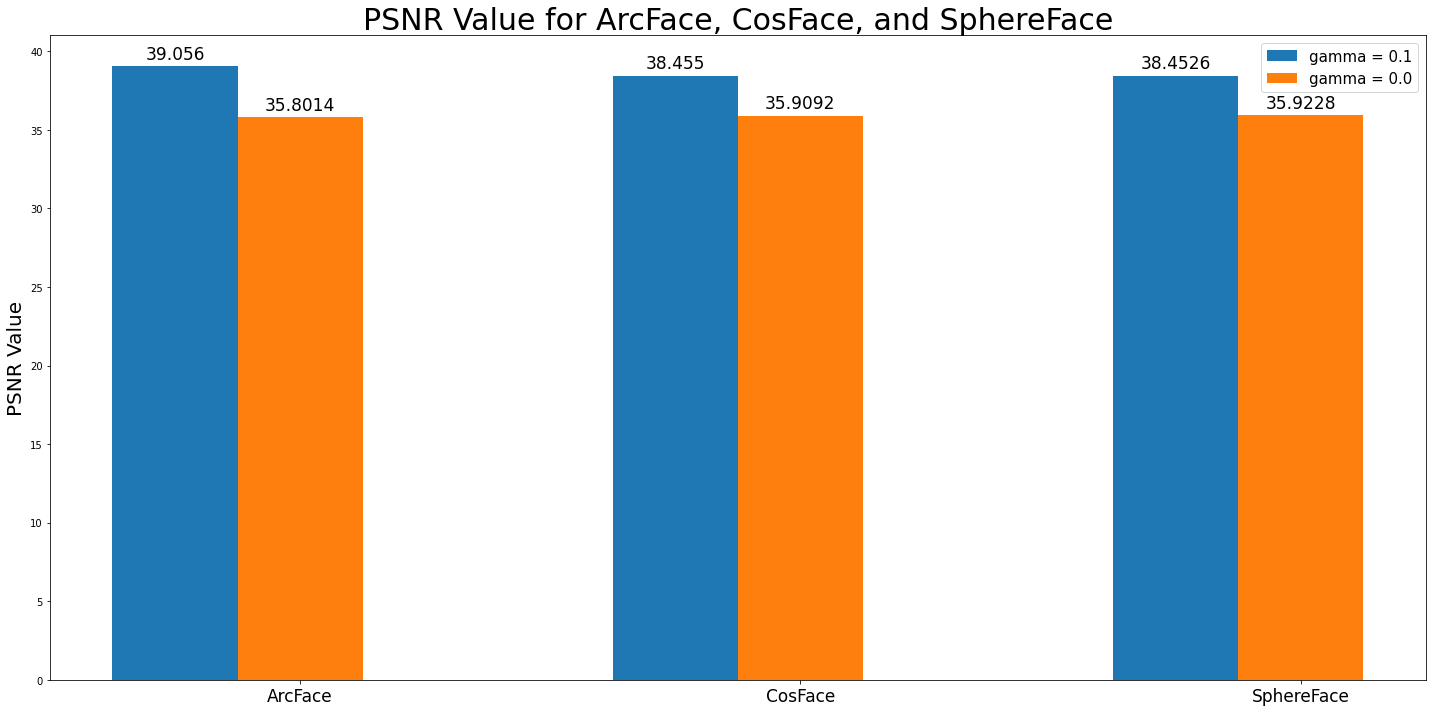

In [35]:
import matplotlib.pyplot as plt

labels = ["ArcFace", "CosFace", "SphereFace"]
gamma1 = [39.0560, 38.4550, 38.4526] #0.1 gamma
gamma0 = [35.8014, 35.9092, 35.9228] #0.0 gamma

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width, gamma1, width, label='gamma = 0.1')
rects2 = ax.bar(x, gamma0, width, label='gamma = 0.0')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('PSNR Value', fontsize=20)
ax.set_title('PSNR Value for ArcFace, CosFace, and SphereFace', fontsize=30)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=17)
ax.legend(prop={'size': 15})


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=17)


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# SSIM

In [36]:
persons = {}
mark = ''
with open('/content/gdrive/MyDrive/TIP-IM/data/pairs.txt', 'r') as f:
    for pair in f.readlines()[:87]:
        person = pair.strip()
        person, id1, id2 = person.split('\t')
        if person == mark:
          persons[person] = id2
        else:
          mark = person
          persons[person] = id2
persons

{'Abel_Pacheco': '4',
 'Akhmed_Zakayev': '3',
 'Amber_Tamblyn': '2',
 'Anders_Fogh_Rasmussen': '4',
 'Angela_Bassett': '4',
 'Ann_Veneman': '11',
 'Anthony_Fauci': '2',
 'Antony_Leung': '3',
 'Anwar_Ibrahim': '2',
 'Augusto_Pinochet': '2',
 'Barbara_Brezigar': '2',
 'Benjamin_Netanyahu': '5',
 'Bernard_Law': '4',
 'Bertrand_Bonello': '2',
 'Bill_Frist': '5',
 'Bob_Graham': '6',
 'Boris_Becker': '6',
 'Brad_Johnson': '4',
 'Brian_Griese': '2',
 'Candice_Bergen': '3',
 'Carla_Myers': '2',
 'Cathy_Freeman': '2',
 'Chang_Dae-whan': '2',
 'Charles_Grassley': '2',
 'Clare_Short': '4',
 'Corinne_Coman': '2',
 'Dai_Bachtiar': '2',
 'Dale_Earnhardt_Jr': '3',
 'David_Caruso': '2',
 'Demi_Moore': '3',
 'Dick_Vermeil': '2',
 'Doris_Roberts': '3',
 'Drew_Barrymore': '2',
 'Edmund_Stoiber': '11',
 'Elinor_Caplan': '2',
 'Emmanuelle_Beart': '3',
 'Federico_Trillo': '3',
 'Francis_Ford_Coppola': '2',
 'Fred_Thompson': '3',
 'Garry_Trudeau': '2',
 'Gary_Williams': '2',
 'Gene_Robinson': '3',
 'George_G

In [42]:
from skimage.metrics import structural_similarity as ssim

avg_ssim = 0
max_ssim = -2
min_ssim = 2
ssim_list = []

for name in persons:
  #img1 = cv2.imread('/content/gdrive/MyDrive/TIP-IM/output/exppriv/'+name+'-12.png')#.astype(np.float32)    #ArcFace-gamma0.0
  #img1 = cv2.imread('/content/gdrive/MyDrive/TIP-IM/output-ArcFace-gamma0.1/exppriv/'+name+'-12.png')#.astype(np.float32)
  #img1 = cv2.imread('/content/gdrive/MyDrive/output-CosFace-gamma0.0/exppriv/'+name+'-12.png')#.astype(np.float32)
  #img1 = cv2.imread('/content/gdrive/MyDrive/output-CosFace-gamma0.1/exppriv/'+name+'-12.png')#.astype(np.float32)
  #img1 = cv2.imread('/content/gdrive/MyDrive/TIP-IM/exppriv_SphereFace_0.1/exppriv_SphereFace_0.1/'+name+'-12.png')#.astype(np.float32)
  img1 = cv2.imread('/content/gdrive/MyDrive/TIP-IM/exppriv_SphereFace/exppriv_SphereFace/'+name+'-12.png')#.astype(np.float32)


  img2 = cv2.imread('/content/gdrive/MyDrive/TIP-IM/data/LFW/{}/{}_{:04d}.jpg'.format(name, name, int(persons[name])))
  SSIM = ssim(img1, img2, multichannel = True)
  ssim_list.append(SSIM)

  if (SSIM >= max_ssim):
    max_ssim = SSIM
  elif (SSIM <= min_ssim):
    min_ssim = SSIM
  avg_ssim += SSIM
  

print("===> Avg. SSIM: {:.4f} dB".format(avg_ssim / 50))
print("===> Max SSIM: {:.4f} dB".format(max_ssim))
print("===> Min SSIM: {:.4f} dB".format(min_ssim))

===> Avg. SSIM: 0.9623 dB
===> Max SSIM: 0.9835 dB
===> Min SSIM: 0.9327 dB


In [ ]:
import matplotlib.pyplot as plt

labels = ["ArcFace", "CosFace", "SphereFace"]
gamma1 = [0.9887, 0.9870, 0.9870] #0.1 gamma
gamma0 = [0.9607, 0.9621, 0.9623] #0.0 gamma

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 12))
rects1 = ax.bar(x - width, gamma1, width, label='gamma = 0.1')
rects2 = ax.bar(x, gamma0, width, label='gamma = 0.0')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('SSIM Value', fontsize=20)
ax.set_title('SSIM Value for ArcFace, CosFace, and SphereFace', fontsize=30)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=17)
ax.legend(prop={'size': 10})


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=17)


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

#Rank-N-T & Rank-N-UT Evaluation

In [6]:
attacker_persons = []
with open('/content/gdrive/MyDrive/TIP-IM/data/pairs.txt', 'r') as f:
    for pair in f.readlines()[:87]:
    #for pair in f.readlines()[:10]:
        attacker_person = pair.strip()
        attacker_persons.append(attacker_person)


# attack_name, id1, id2 = attacker_persons[j].split('\t')
# original_img = imread("/content/gdrive/MyDrive/TIP-IM/data/LFW/{}/{}_{:04d}.jpg".format(attack_name, attack_name, int(id2))).astype(np.float32)
model, img_shape = getmodel('SphereFace') # White-box Model
batch_size = 1
n = len(attacker_persons)
m = 1.0
names = []
for i in tqdm(range(0, n, batch_size)):
    l, r = i, min(i + batch_size, n)
    
    for j in range(l, r):
        attack_name, id1, id2 = attacker_persons[j].split('\t')
        names.append(attack_name)
        
        
    
names = set(names)
names = list(names)
print(len(names))

Load existing checkpoint
No existing checkpoint, now downloading online
Finish downloading
Load checkpoint


100%|██████████| 87/87 [00:00<00:00, 399239.00it/s]

50


In [7]:
gallery_set = []
gallery = os.listdir('/content/gdrive/MyDrive/TIP-IM/gallery')
for image in os.listdir('/content/gdrive/MyDrive/TIP-IM/gallery'):
  gallery_img = imread('/content/gdrive/MyDrive/TIP-IM/gallery/'+image).astype(np.float32)
  align_target_img, _= align(gallery_img)
  align_target_img = cv2.resize(align_target_img, (img_shape[1], img_shape[0]))
  gallery_feas = inference(align_target_img, model, image_shape = img_shape)
  gallery_feas = Variable(gallery_feas)
  gallery_feas = gallery_feas.cpu().data
  gallery_feas = np.array(gallery_feas)
  gallery_set.append(gallery_feas)
gallery_set = np.array(gallery_set).reshape(233,-1)
print(gallery_set.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


(233, 512)


In [8]:
protected_set = []
for name in names:
  protected_img = imread('/content/gdrive/MyDrive/output-ArcFace-gamma0.007/exppriv/'+name+'-12.png').astype(np.float32) #0.001
  protected_feas = inference(protected_img, model, image_shape = img_shape)
  protected_feas = Variable(protected_feas)
  protected_feas = protected_feas.cpu().data
  protected_feas = np.array(protected_feas)
  protected_set.append(protected_feas)
# protected_set = np.array(protected_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
top5 = []
for pro_img in protected_set:
  distance = []
  min = []
  for gal_img in gallery_set:
    dist = np.linalg.norm(pro_img - gal_img)
    distance.append(dist)

  for i in range(5):
    
    ind = np.argmin(distance)
    min.append(ind)
    distance[ind] = 9999
  top5.append(np.array(min))
print(top5)

[array([ 42,  40, 210,  91,  56]), array([101,  37,  17,  69, 172]), array([188, 115, 122, 111, 218]), array([162,  27,  29,  45,  48]), array([213,   1,  75, 195, 190]), array([187, 178, 181, 130,  75]), array([72, 70, 40, 91, 55]), array([121,  95, 114,  98, 120]), array([226,  12, 106,  30, 100]), array([231, 141, 160, 232, 148]), array([150,  10,  44,  32,   2]), array([221, 218, 219, 102, 188]), array([180, 165, 199, 227,  25]), array([206, 115, 211, 188,  47]), array([230, 200, 112,  64, 169]), array([166, 209,   9, 225, 164]), array([152, 117, 184, 141, 183]), array([220, 128,  14, 189, 144]), array([ 71,  85, 227, 104,  25]), array([133, 132, 232, 231,  84]), array([167, 176,   3,   7,  86]), array([189,  83, 177,  97, 179]), array([191,  96, 121, 180, 109]), array([146, 145,  23,  58, 120]), array([ 53,  28,  43, 227,  82]), array([158, 159,  83,  97, 179]), array([225, 183, 170, 196,   0]), array([182, 103, 130,  34, 104]), array([47, 34, 15, 21, 24]), array([38, 19, 21, 67, 

In [10]:
#taeget set
target_nums = 10
aligned_target_imgs = []
target_persons = []
target_names = []
with open('/content/gdrive/MyDrive/TIP-IM/targets/target_attacks.txt', 'r') as f:
    for line in f.readlines():
        target_person = line.strip()
        # name, id1, id2 = target_person.split('\t')
        # target_names.append(name)
        target_persons.append(target_person)
        temp = target_person.split('/')
        target_names.append(temp[-2])

for i in range(target_nums):
    target_img = imread(target_persons[i]).astype(np.float32)
    align_target_img, _= align(target_img)
    align_target_img = cv2.resize(align_target_img, (img_shape[1], img_shape[0]))
    aligned_target_imgs.append(align_target_img)
aligned_target_imgs = np.array(aligned_target_imgs)        

# extract features of targets
target_feas = inference(aligned_target_imgs, model, image_shape = img_shape)
target_feas = Variable(target_feas)

#name of top5
top5_name = []
for i in top5:
  name_list = []
  for j in i:
    img = gallery[j]
    people_name, num = img.rsplit('_',1)
    name_list.append(people_name)
  top5_name.append(name_list)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


## Rank-5-T

In [11]:
#rank-n-t
count = 0
for i in top5_name:
  for j in i:
    if j in target_names:
      count = count + 1
      break
print(count/50)

0.26


## Rank-5-UT

In [12]:
count = 0
for i in range(50):
  if names[i] not in top5_name[i]:
    count = count + 1
print(count/50)

0.0


## Rank-1-T

In [13]:
count = 0
for i in top5_name:
  if i[0] in target_names:
    count = count + 1
print(count/50)

0.04


## Rank-1-UT

In [14]:
count = 0
for i in range(50):
  if names[i] != top5_name[i][0]:
    count = count + 1
print(count/50)

0.0
